In [1]:
from pathlib import Path
import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image

from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score

PROJECT_ROOT = Path(r"C:\Users\othni\Projects\mvtec_ad")
EXPERIMENTS_DIR = PROJECT_ROOT / "experiments"
MODELS_DIR = PROJECT_ROOT / "models"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [2]:
train_csv_path = EXPERIMENTS_DIR / "image_level_train_split.csv"
val_csv_path   = EXPERIMENTS_DIR / "image_level_val_split.csv"
test_csv_path  = EXPERIMENTS_DIR / "image_level_test_split.csv"

df_train = pd.read_csv(train_csv_path)
df_val   = pd.read_csv(val_csv_path)
df_test  = pd.read_csv(test_csv_path)

print("Train:", df_train.shape)
print("Val  :", df_val.shape)
print("Test :", df_test.shape)

print("\nVal label counts :")
print(df_val["label"].value_counts())

Train: (3747, 6)
Val  : (803, 6)
Test : (804, 6)

Val label counts :
label
0    614
1    189
Name: count, dtype: int64


In [3]:
class MVTecImageLevelDataset(Dataset):
    def __init__(self, df_split, transform=None):
        self.df = df_split.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = Path(row["path"])
        label = int(row["label"])

        img = Image.open(img_path).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.float32)

In [4]:
eval_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_ds = MVTecImageLevelDataset(df_val, transform=eval_transform)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=0)

len(val_ds)

803

In [5]:
best_model_path = MODELS_DIR / "resnet18_image_level_best.pt"

best_model = models.resnet18(weights=None)
in_features = best_model.fc.in_features
best_model.fc = nn.Linear(in_features, 1)

best_model.load_state_dict(torch.load(best_model_path, map_location=device))
best_model = best_model.to(device)
best_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
all_labels = []
all_scores = []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        logits = best_model(imgs).squeeze(1)  # (B,)
        all_labels.append(labels.detach().cpu().numpy())
        all_scores.append(logits.detach().cpu().numpy())

y_val = np.concatenate(all_labels)          # labels (0/1)
logits_val = np.concatenate(all_scores)     # logits
probs_val = 1 / (1 + np.exp(-logits_val))   # sigmoid

print("y_val shape:", y_val.shape)
print("probs_val shape:", probs_val.shape)
print("Label counts val:", np.bincount(y_val.astype(int)))

y_val shape: (803,)
probs_val shape: (803,)
Label counts val: [614 189]


In [7]:
thresholds = np.linspace(0.0, 1.0, 1001)  # 0.000, 0.001, ..., 1.000

results = []

for tau in thresholds:
    y_pred = (probs_val >= tau).astype(int)
    
    # pour éviter des warnings sur division par zéro
    if y_pred.sum() == 0:
        precision = 0.0
    else:
        precision = precision_score(y_val, y_pred, zero_division=0)
    recall    = recall_score(y_val, y_pred, zero_division=0)
    f1        = f1_score(y_val, y_pred, zero_division=0)
    f2        = fbeta_score(y_val, y_pred, beta=2, zero_division=0)
    
    results.append({
        "tau": tau,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "f2": f2,
    })

results_df = pd.DataFrame(results)
results_df.head()

,tau,precision,recall,f1,f2
0,0.000,0.235367,1.0,0.381048,0.606158
1,0.001,0.267327,1.0,0.421875,0.645933
2,0.002,0.281250,1.0,0.439024,0.661765
3,0.003,0.290323,1.0,0.450000,0.671642
4,0.004,0.303859,1.0,0.466091,0.685776


In [8]:
# Seuil max F1 global
idx_f1 = results_df["f1"].idxmax()
row_f1 = results_df.loc[idx_f1]

# Seuil max F2 global
idx_f2 = results_df["f2"].idxmax()
row_f2 = results_df.loc[idx_f2]

print("==== Max F1 ====")
print(row_f1)

print("\n==== Max F2 ====")
print(row_f2)

==== Max F1 ====
tau          0.820000
precision    0.851675
recall       0.941799
f1           0.894472
f2           0.922280
Name: 820, dtype: float64

==== Max F2 ====
tau          0.806000
precision    0.844340
recall       0.947090
f1           0.892768
f2           0.924587
Name: 806, dtype: float64


In [9]:
# Seuils avec rappel parfait (aucun FN sur la validation)
safe_candidates = results_df[results_df["recall"] == 1.0].copy()

print("Nombre de seuils avec recall=1.0 :", len(safe_candidates))

if len(safe_candidates) > 0:
    # option 1 : prendre celui avec la meilleure F1 parmi eux
    idx_safe = safe_candidates["f1"].idxmax()
    row_safe = results_df.loc[idx_safe]
else:
    # sinon, on prend le seuil avec recall >= 0.995 (si disponible)
    safe_candidates = results_df[results_df["recall"] >= 0.995].copy()
    print("Nombre de seuils avec recall>=0.995 :", len(safe_candidates))
    if len(safe_candidates) > 0:
        idx_safe = safe_candidates["f1"].idxmax()
        row_safe = results_df.loc[idx_safe]
    else:
        # fallback : on prend celui de max F2
        row_safe = row_f2

print("\n==== Seuil SAFE (priorité au rappel) ====")
print(row_safe)

Nombre de seuils avec recall=1.0 : 24

==== Seuil SAFE (priorité au rappel) ====
tau          0.023000
precision    0.416300
recall       1.000000
f1           0.587869
f2           0.780992
Name: 23, dtype: float64


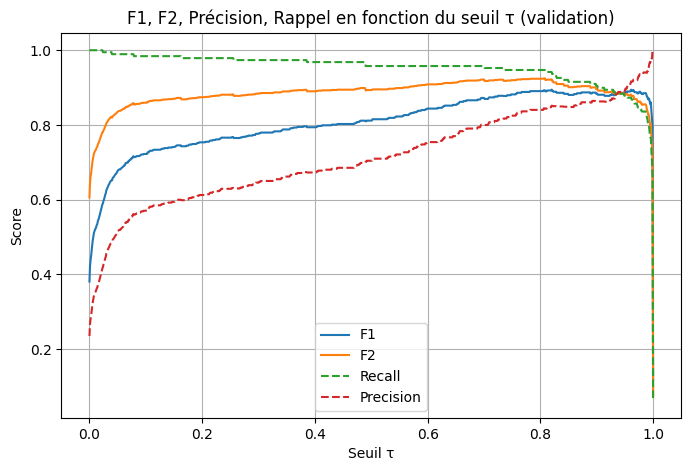

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(results_df["tau"], results_df["f1"], label="F1")
plt.plot(results_df["tau"], results_df["f2"], label="F2")
plt.plot(results_df["tau"], results_df["recall"], label="Recall", linestyle="--")
plt.plot(results_df["tau"], results_df["precision"], label="Precision", linestyle="--")
plt.xlabel("Seuil τ")
plt.ylabel("Score")
plt.title("F1, F2, Précision, Rappel en fonction du seuil τ (validation)")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# === DataLoader pour le test ===
test_ds = MVTecImageLevelDataset(df_test, transform=eval_transform)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=0)

len(test_ds)

804

In [12]:
# === Logits et probabilités sur le TEST ===
all_labels_test = []
all_scores_test = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        logits = best_model(imgs).squeeze(1)
        all_labels_test.append(labels.detach().cpu().numpy())
        all_scores_test.append(logits.detach().cpu().numpy())

y_test = np.concatenate(all_labels_test)
logits_test = np.concatenate(all_scores_test)
probs_test = 1 / (1 + np.exp(-logits_test))

print("y_test shape:", y_test.shape)
print("Label counts test:", np.bincount(y_test.astype(int)))

y_test shape: (804,)
Label counts test: [615 189]


In [13]:
from sklearn.metrics import confusion_matrix

def eval_at_threshold(probs, y_true, tau, name=""):
    y_pred = (probs >= tau).astype(int)
    
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall    = recall_score(y_true, y_pred, zero_division=0)
    f1        = f1_score(y_true, y_pred, zero_division=0)
    f2        = fbeta_score(y_true, y_pred, beta=2, zero_division=0)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    print(f"\n=== {name} (tau = {tau:.3f}) ===")
    print(f"Precision : {precision:.4f}")
    print(f"Recall    : {recall:.4f}")
    print(f"F1        : {f1:.4f}")
    print(f"F2        : {f2:.4f}")
    print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")
    
    return {
        "tau": tau,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "f2": f2,
        "tn": tn, "fp": fp, "fn": fn, "tp": tp,
    }

In [14]:
tau_f1   = float(row_f1["tau"])
tau_f2   = float(row_f2["tau"])
tau_safe = float(row_safe["tau"])

print("tau_F1*  :", tau_f1)
print("tau_F2*  :", tau_f2)
print("tau_safe :", tau_safe)

# --- Évaluation sur VALIDATION ---
print("\n######## Validation ########")
res_val_f1   = eval_at_threshold(probs_val,  y_val,   tau_f1,   name="VAL - Max F1")
res_val_f2   = eval_at_threshold(probs_val,  y_val,   tau_f2,   name="VAL - Max F2")
res_val_safe = eval_at_threshold(probs_val,  y_val,   tau_safe, name="VAL - SAFE")

# --- Évaluation sur TEST ---
print("\n######## Test ########")
res_test_f1   = eval_at_threshold(probs_test, y_test, tau_f1,   name="TEST - Max F1")
res_test_f2   = eval_at_threshold(probs_test, y_test, tau_f2,   name="TEST - Max F2")
res_test_safe = eval_at_threshold(probs_test, y_test, tau_safe, name="TEST - SAFE")

tau_F1*  : 0.8200000000000001
tau_F2*  : 0.806
tau_safe : 0.023

######## Validation ########

=== VAL - Max F1 (tau = 0.820) ===
Precision : 0.8517
Recall    : 0.9418
F1        : 0.8945
F2        : 0.9223
TN=583, FP=31, FN=11, TP=178

=== VAL - Max F2 (tau = 0.806) ===
Precision : 0.8443
Recall    : 0.9471
F1        : 0.8928
F2        : 0.9246
TN=581, FP=33, FN=10, TP=179

=== VAL - SAFE (tau = 0.023) ===
Precision : 0.4163
Recall    : 1.0000
F1        : 0.5879
F2        : 0.7810
TN=349, FP=265, FN=0, TP=189

######## Test ########

=== TEST - Max F1 (tau = 0.820) ===
Precision : 0.8216
Recall    : 0.9259
F1        : 0.8706
F2        : 0.9030
TN=577, FP=38, FN=14, TP=175

=== TEST - Max F2 (tau = 0.806) ===
Precision : 0.8111
Recall    : 0.9312
F1        : 0.8670
F2        : 0.9044
TN=574, FP=41, FN=13, TP=176

=== TEST - SAFE (tau = 0.023) ===
Precision : 0.4202
Recall    : 0.9894
F1        : 0.5899
F2        : 0.7785
TN=357, FP=258, FN=2, TP=187


In [15]:
import json

thresholds = {
    "image_level_global": {
        "tau_F1":   float(tau_f1),
        "tau_F2":   float(tau_f2),
        "tau_safe": float(tau_safe),
    }
}

thr_path = EXPERIMENTS_DIR / "image_level_thresholds.json"
with open(thr_path, "w") as f:
    json.dump(thresholds, f, indent=2)

thr_path, thresholds

(WindowsPath('C:/Users/othni/Projects/mvtec_ad/experiments/image_level_thresholds.json'),
 {'image_level_global': {'tau_F1': 0.8200000000000001,
   'tau_F2': 0.806,
   'tau_safe': 0.023}})

In [16]:
with open(thr_path, "r") as f:
    thresholds = json.load(f)
tau_safe = thresholds["image_level_global"]["tau_safe"]